# Jupyter notebook to work with the data

I just created a separate live notebook so we can focus on the stuff that we find relevant and remove the other stuff, whilst still being able to easily take a look at it

## Ideas
- Seems to be related to change detection, could use similar methods https://en.wikipedia.org/wiki/Change_detection
- Can have two steps:
    1. Train initially on all the regular, full datasets given (or at least as many as the computer can handle), use some sort of change detection algorithm to analyse previous data and determine where quake happened
    2. Probably more impressive and more likely to make us win, could we predict a quake was about to happen *before* it occurs? Don't know if this is possible, but maybe there are mini vibrations or something before the main ones? This would be good for presentation as would reduce amount of storage space required to hold old data and all that, can simply start recording when a quake is about to start

# Read in and plot the Apollo 12 Grade A catalog

In [5]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

catalogue(filename, time, ...) -> file(times, velocity, ...)
The catalogue has the info about when the events occur for training

Let's take a look at the training data for the lunar dataset. In addition to the data itself, we include a catalog that will tell you which events happen when in the data. The catalog includes the name of the file, the absolute time, the relative time in seconds (relative to the start of the file), the event ID (evid), and the type of moonquake. The types of moonquakes include impacts, deep moonquakes, and shallow moonquakes. You do not have to worry about predicting the type of moonquakes, that's just fun information for you to know! 

**Note**: For your prediction, feel free to include either the absolute time or relative time, just make sure to mark it using the same header in the CSV file so we can easily score it!

In [3]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [4]:
# Check whether there are two quakes in any of the data. There isn't.
len(cat['filename'])-len(cat['filename'].drop_duplicates())

0

## Select a detection

Let's pick the first seismic event in the catalog and let's take a look at the absolute time data. The way we show it here is by using pandas `.iloc` and datetime `.strptime`. We are going to keep the format shown in the absolute time header, which is `'%Y-%m-%dT%H:%M:%S.%f'`

In [5]:
row = cat.iloc[6]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1970, 6, 26, 20, 1)

In [6]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

np.float64(72060.0)

In [7]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1970-06-26HR00_evid00009'

## Read the CSV file corresponding to that detection

We will now find the csv data file corresponding to that time and plot it!

In [8]:
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-06-26T00:00:00.116000,0.000000,-6.727977e-16
1,1970-06-26T00:00:00.266943,0.150943,-8.646711e-16
2,1970-06-26T00:00:00.417887,0.301887,-9.298738e-16
3,1970-06-26T00:00:00.568830,0.452830,-8.589095e-16
4,1970-06-26T00:00:00.719774,0.603774,-7.139047e-16
...,...,...,...
572418,1970-06-27T00:00:02.832981,86402.716981,5.039820e-17
572419,1970-06-27T00:00:02.983925,86402.867925,-9.191068e-18
572420,1970-06-27T00:00:03.134868,86403.018868,-2.796955e-17
572421,1970-06-27T00:00:03.285811,86403.169811,-9.037156e-17


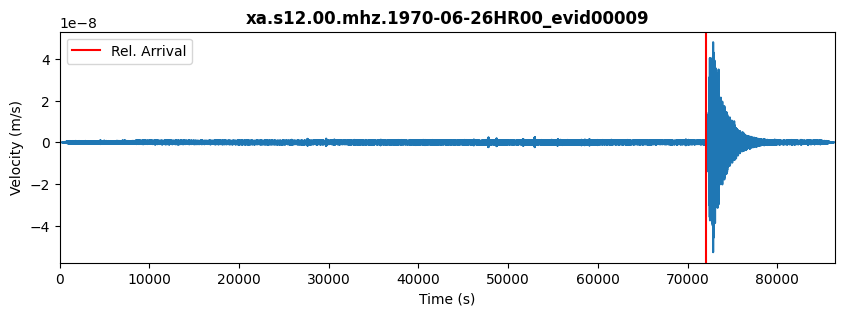

In [9]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

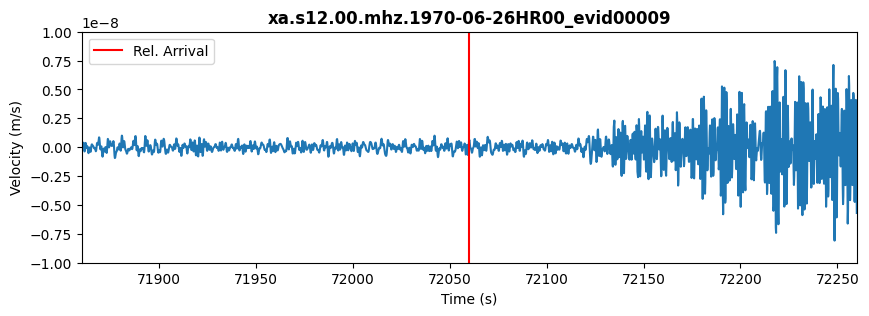

In [10]:
# Thought I'd zoom in a bit to just make things clearer
# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([arrival_time_rel - 200 ,arrival_time_rel + 200])
ax.set_ylim([-0.00000001, 0.00000001])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

What if you wanted to plot in absolute time instead? The operations are very similar, just with a little extra datetime. It takes a bit longer, so we recommend working in relative time to start with!

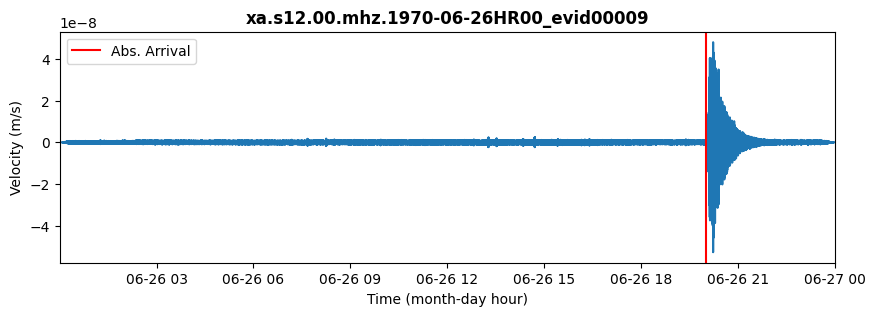

In [11]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

## Alternatively: read the miniseed file corresponding to that detection

Same procedure as above, just using the miniseed file. 

In [12]:
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-06-26T00:00:00.116000Z - 1970-06-27T00:00:03.436755Z | 6.6 Hz, 572423 samples

In [13]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-06-26T00:00:00.116000Z
         endtime: 1970-06-27T00:00:03.436755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [14]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

72059.884

### Plot the trace and mark the arrival! 

Use a similar method to plot the miniseed data and seismic arrival.

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-06-26HR00_evid00009')

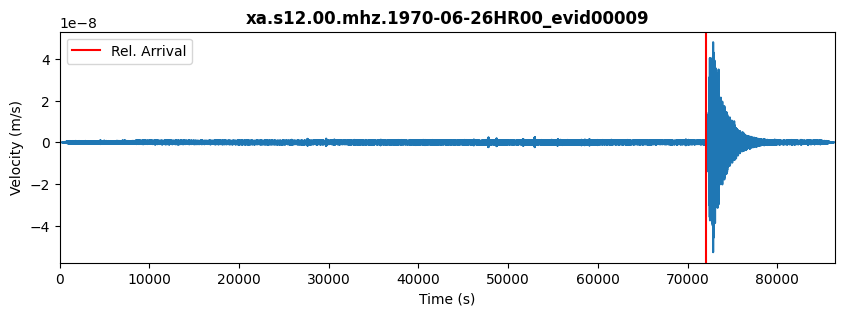

In [15]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

There are multiple ways that we can do the absolute time using datetime, here is a simple way using the `.timedelta` method

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-06-26HR00_evid00009')

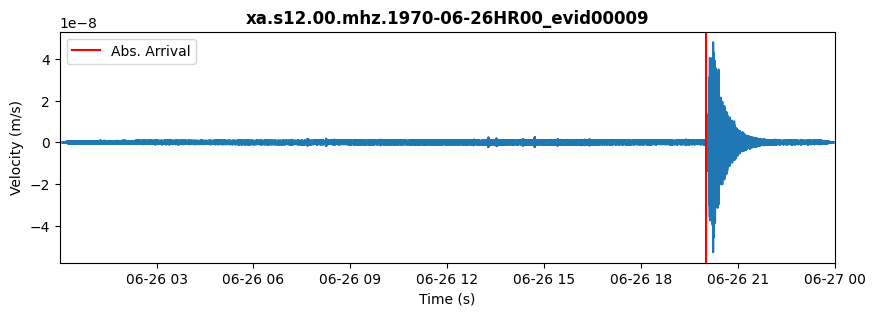

In [16]:
# Create a vector for the absolute time
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

# Plot the absolute result
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times_dt,tr_data)

# Mark detection
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

# Make the plot pretty
ax.set_xlim([min(tr_times_dt),max(tr_times_dt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')


It's completely up to you whether to work with the CSV file or the miniseed files. We recommend working with the miniseed file as it's a bit faster to run. 

## Let's filter the trace

Sometimes, it's useful to filter the trace to bring out particular frequencies. This will change the shape of the data and make it easier to see certain parts of the signal. In this example, we will filter the data using a bandpass filter between 0.01 Hz to 0.5 Hz. 

In [17]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [18]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

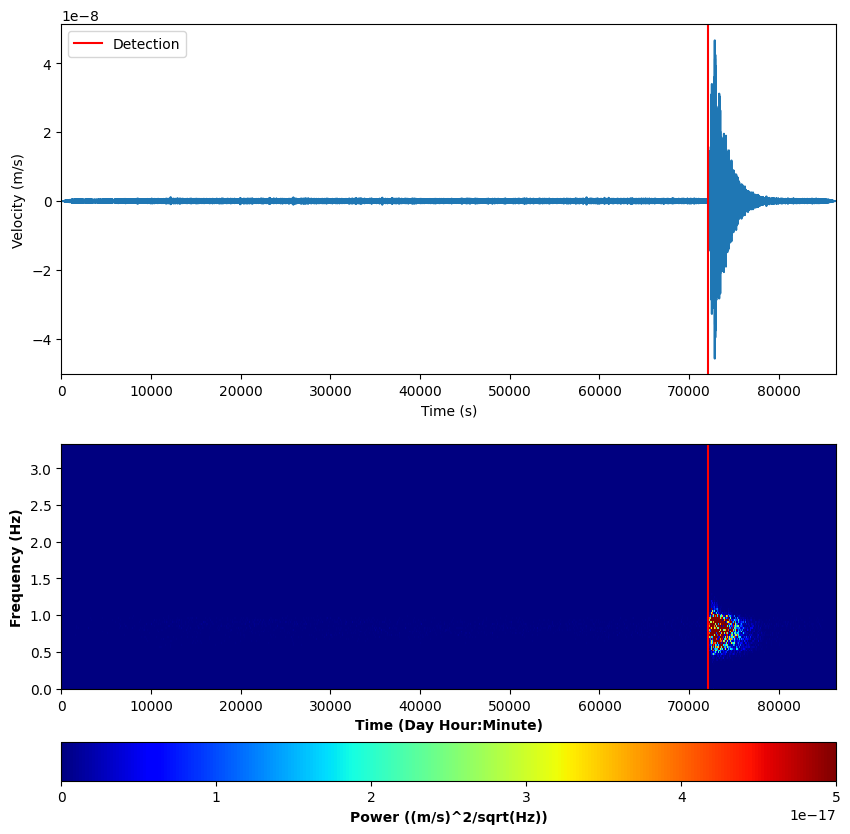

In [19]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

## Creating RNN to detect anomalies (the quakes)

We want to split the dataset into anomaly and non anomaly sections. Then we can use a binary classifier with the RNN, should simplify the training. Then we can run a sliding window until a binary classification of anomaly is made.

In [6]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [ ]:
# %%time
# # Load the catalogue CSV that contains filenames and the quake time

# # Assuming your catalogue has two columns: 'filename' and 'quake_time'
# # filename: the path to the training file
# # quake_time: the time (relative) at which the quake occurs

# all_data = []
# data_dir = './data/lunar/training/data/S12_GradeA/'

# # Process each file in the catalogue
# for index, row in catalogue.iterrows():
#     filename = row['filename']
#     quake_time = row['time_rel(sec)']
    
#     # Load the corresponding training file (assuming it's a CSV or similar format)
#     # Assuming each training file has columns like 'time' and 'amplitude'
#     st = read(f'{data_dir}{filename}.mseed')
    
    
#     # Split the data into two parts: before and after the quake
#     before_quake = df[df['time'] < quake_time].copy()
#     after_quake = df[df['time'] >= quake_time].copy()

#     # Label the data: before quake is labeled '0', after quake is labeled '1'
#     before_quake['label'] = 0
#     after_quake['label'] = 1

#     # Concatenate both parts
#     labeled_data = pd.concat([before_quake, after_quake])
    
#     # Store the labeled data in a list
#     all_data.append(labeled_data)

# # Combine all the labeled data from each file into one large DataFrame
# final_dataset = pd.concat(all_data, ignore_index=True)


In [7]:
%%time
from obspy.core import UTCDateTime

# Assuming your catalogue has two columns: 'filename' and 'time_rel(sec)'
data_dir = './data/lunar/training/data/S12_GradeA/'

# Create an empty list to store all labeled data
all_data = []

# Process each file in the catalogue
for index, row in cat.iterrows():
    filename = row['filename']
    quake_time_rel = row['time_rel(sec)']

    try:
    # Load the corresponding MiniSEED file using obspy
        st = read(f'{data_dir}{filename}.mseed')
    except:
        continue
    
    # Assuming the MiniSEED file contains only one trace (if multiple, process accordingly)
    tr = st[0]  # Extract the first (and only) trace from the stream
    
    # Get the trace start time (absolute) and the relative quake time
    trace_start_time = tr.stats.starttime  # UTCDateTime
    quake_time_abs = trace_start_time + quake_time_rel  # Absolute quake time (UTCDateTime)
    
    # Get the times for each sample point in the trace
    times = np.array([trace_start_time + t for t in tr.times()])  # Array of absolute times for each sample

    # Split the data into two parts: before and after the quake
    before_quake_mask = times < quake_time_abs
    after_quake_mask = times >= quake_time_abs

    # Extract amplitude values (the data) and corresponding times
    amplitudes = tr.data  # The amplitude values of the trace (same length as 'times')

    # Create labeled data arrays
    before_quake_amplitudes = amplitudes[before_quake_mask]
    before_quake_times = times[before_quake_mask]
    
    after_quake_amplitudes = amplitudes[after_quake_mask]
    after_quake_times = times[after_quake_mask]

    # Combine the time, amplitude, and label
    before_quake_df = pd.DataFrame({
        'time': before_quake_times,
        'amplitude': before_quake_amplitudes,
        'label': 0
    })

    after_quake_df = pd.DataFrame({
        'time': after_quake_times,
        'amplitude': after_quake_amplitudes,
        'label': 1
    })

    # Concatenate the before and after data
    labeled_data = pd.concat([before_quake_df, after_quake_df])

    # Append the labeled data to the list
    all_data.append(labeled_data)

# Combine all the labeled data into one large DataFrame
final_dataset = pd.concat(all_data, ignore_index=True)

# Save the final dataset as a CSV or use directly
# final_dataset.to_csv('labeled_dataset.csv', index=False)


CPU times: user 4min 41s, sys: 4.52 s, total: 4min 45s
Wall time: 4min 48s


In [8]:
final_dataset.size

128101542

In [9]:
final_dataset.head()

,time,amplitude,label
0,1970-01-19T00:00:00.665000Z,-6.153279e-14,0
1,1970-01-19T00:00:00.815943Z,-7.701288e-14,0
2,1970-01-19T00:00:00.966887Z,-8.396187e-14,0
3,1970-01-19T00:00:01.117830Z,-8.096155e-14,0
4,1970-01-19T00:00:01.268774Z,-7.097599e-14,0


In [10]:
final_dataset[final_dataset['label'] == 1].head()

,time,amplitude,label
486938,1970-01-19T20:25:00.740472Z,9.004942e-10,1
486939,1970-01-19T20:25:00.891415Z,4.575971e-10,1
486940,1970-01-19T20:25:01.042358Z,-4.284551e-10,1
486941,1970-01-19T20:25:01.193302Z,-1.209429e-09,1
486942,1970-01-19T20:25:01.344245Z,-1.350565e-09,1


In [11]:
# from torch import nn, distributions, exp, log
# import torch

# class LSTM_Encoder(nn.Module):

#   def __init__(self, n_features, seq_len, embedding_dim=20):
#     super(LSTM_Encoder, self).__init__()

#     self.seq_len, self.n_features = seq_len, n_features
#     self.embedding_dim = embedding_dim

#     self.rnn = nn.LSTM(
#       input_size=n_features,
#       hidden_size=embedding_dim,
#       num_layers=1,
#       batch_first=True
#     )

#   def forward(self, x):
#     x = x.reshape((1, self.seq_len, self.n_features))
#     _, (hidden_n, _) = self.rnn(x)
#     return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
%%time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assume final_dataset is already created with columns 'time', 'amplitude', and 'label'

# Step 1: Prepare Data
# We only use 'amplitude' as the feature for the RNN, and 'label' as the target
X = final_dataset[['amplitude']].values  # Extract amplitude as the feature
y = final_dataset['label'].values         # Extract labels (0 or 1)

# Step 2: Reshape the data to 3D format (samples, timesteps, features)
# Here, we assume a window size of 100 time steps (can be adjusted)
window_size = 100

def create_sequences(data, labels, window_size):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i + window_size])  # Create sequence for features
        y_seq.append(labels[i + window_size])  # Corresponding label for the end of the sequence
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, window_size)

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Step 4: Normalize/Standardize the data (standardization generally works better for RNNs)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Step 5: Build the GRU Model
model = Sequential()

# Add GRU layer
model.add(GRU(units=64, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))

# Add a second GRU layer (optional, can try with just one GRU layer as well)
model.add(GRU(units=64))
model.add(Dropout(0.2))

# Add Dense layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Step 6: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
